
# Source
- English : https://blog.keras.io/building-autoencoders-in-keras.html
- 한글 : https://keraskorea.github.io/posts/2018-10-23-keras_autoencoder/


In [1]:
import keras
from keras import layers
import matplotlib.pyplot as plt
from keras.optimizers import  Adam

original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2
batch_size=8
epochs=100

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)


In [2]:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [3]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [4]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer=Adam(lr=0.0001))


In [5]:
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))


11493376/11490434 [==============================] - 0s 0us/step
Epoch 1/100
7500/7500 [==============================] - 25s 3ms/step - loss: 206.7420 - val_loss: 179.8229
Epoch 2/100
7500/7500 [==============================] - 25s 3ms/step - loss: 175.5882 - val_loss: 171.9407
Epoch 3/100
7500/7500 [==============================] - 26s 3ms/step - loss: 170.9614 - val_loss: 169.0356
Epoch 4/100
7500/7500 [==============================] - 25s 3ms/step - loss: 168.4238 - val_loss: 166.9668
Epoch 5/100
7500/7500 [==============================] - 26s 3ms/step - loss: 166.5638 - val_loss: 165.5702
Epoch 6/100
7500/7500 [==============================] - 26s 3ms/step - loss: 165.1550 - val_loss: 164.4481
Epoch 7/100
7500/7500 [==============================] - 25s 3ms/step - loss: 164.0953 - val_loss: 163.6369
Epoch 8/100
7500/7500 [==============================] - 26s 3ms/step - loss: 163.2726 - val_loss: 162.9194
Epoch 9/100
7500/7500 [==============================] - 26s 3ms/step -

In [6]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
x_test_encoded[0].shape,x_test_encoded[1].shape,x_test_encoded[2].shape


((10000, 2), (10000, 2), (10000, 2))

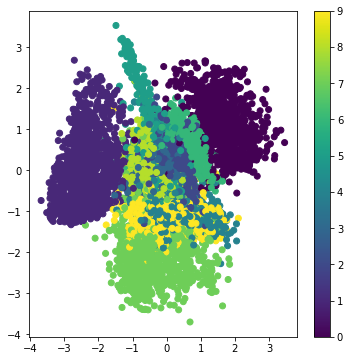

In [17]:

plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[0][:, 0], x_test_encoded[0][:, 1], c=y_test)
plt.colorbar()
plt.show()



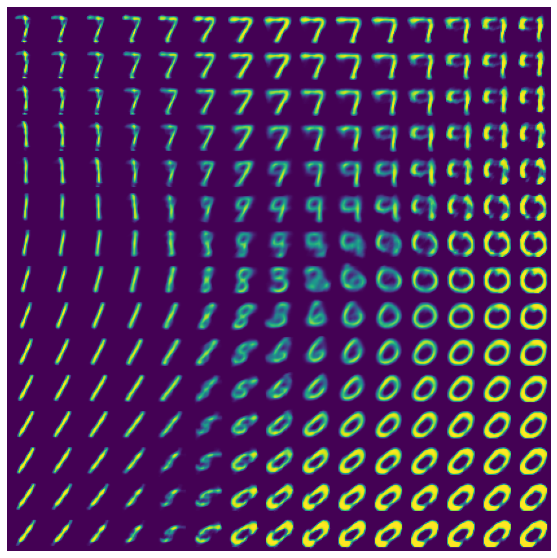

In [16]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-4, 4] standard deviations
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.axis(False)
plt.imshow(figure)
plt.show()